# Practice NumPy

Make sure you look at [`Intro_to_NumPy.ipynb`](Intro_to_NumPy.ipynb) first!

In [4]:
import numpy as np

from utils import vp_from_dt, impedance, rc_series

In [5]:
test = np.random.random(10000000)

In [6]:
%timeit rc_series(test)

4.49 s ± 60.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Note that the log has to be fairly big for the benchmarking to work properly, because otherwise the CPU caches the computation and this skews the results.

Now we can re-write our function using arrays instead of lists. Let's just remind ourselves of what it looked like before:

In [7]:
import inspect
print(inspect.getsource(rc_series))

def rc_series(z):
    upper = z[:-1]
    lower = z[1:]
    rc = []
    for u, l in zip(upper, lower):
        rc.append((l-u)/(l+u))
    return rc



## Exercise

- Rewrite the `rc_series()` function to get rid of the loop. Remember that the math operations work on the entire array at once.
- Time your new version on the `test` data and compare to the loop version.

In [8]:
def rc_vector(layers):
    
    # Your code here.
    
    return rc

In [22]:
z = np.arange(10)
rc_vector(z)

array([ 1.        ,  0.33333333,  0.2       ,  0.14285714,  0.11111111,
        0.09090909,  0.07692308,  0.06666667,  0.05882353])

You should get the same output as you did before:

In [10]:
z = np.arange(10)
rc_series(z)

[1.0,
 0.33333333333333331,
 0.20000000000000001,
 0.14285714285714285,
 0.1111111111111111,
 0.090909090909090912,
 0.076923076923076927,
 0.066666666666666666,
 0.058823529411764705]

In [11]:
def rc_vector(z):
    uppers = z[:-1]
    lowers = z[1:]
    return (lowers - uppers) / (uppers + lowers)

In [12]:
%timeit rc_vector(test)

78.8 ms ± 1.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


60+ times faster on my machine!

## Exercise

- Run the `rc_series` function on the log data to make an RC series array.
- Add the vectorized version to the file `utils.py`.

In [15]:
from welly import Well

w = Well.from_las('../data/R-39.las')

dt = np.array(w.data['DT4P'])
rhob = np.array(w.data['RHOB'])

In [25]:
vp =  # Your code here
z =   # Your code here
rc =  # Your code here

In [16]:
vp = vp_from_dt(dt)

In [17]:
z = impedance(vp, rhob)

In [18]:
rc = rc_series(z)

In [19]:
rc[:10]

[0.00088800429199709151,
 0.00042668570200545187,
 0.00086730096657770697,
 -0.0010406009309613957,
 -0.00083023113831957396,
 0.00084322362252095605,
 0.00090627409322461628,
 3.2456371927591016e-05,
 -0.0017628465379843968,
 -0.0014637098104735337]

## A very brief introduction to plotting

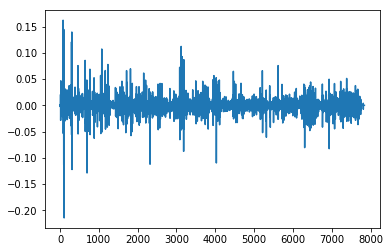

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(rc)

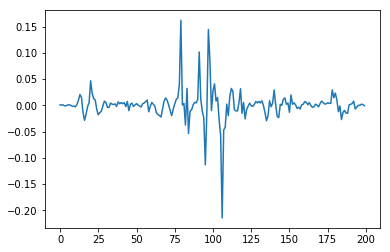

In [35]:
plt.plot(rc[:200])

<Container object of 3 artists>

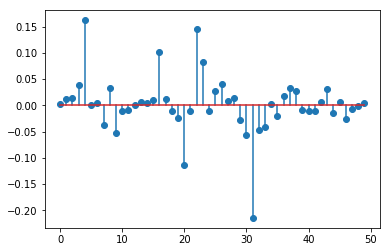

In [38]:
plt.stem(rc[75:125])

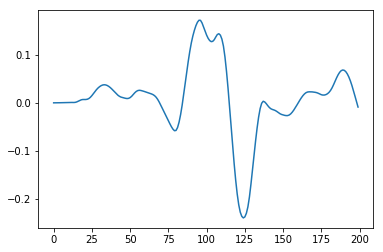

In [34]:
theta = np.arange(0, np.pi, 0.1)
y = np.sin(theta)**2

s = np.convolve(y, rc)
plt.plot(s[:200])

## Vsh

_V_<sub>sh</sub> or _V_<sub>shale</sub> is the volume of shale in a given volume of rock. Often synonymous with _V_<sub>clay</sub>, though strictly speaking this should be measured at a different scale: _V_<sub>clay</sub> pertains to a rock, whereas _V_<sub>sh</sub> pertains to an interval of strata. 

It is possible to calculate _V_<sub>sh</sub> from spectral gamma-ray CGR curve data (usually where GR comes from):

$$x = \frac{\mathsf{CGR}_\mathrm{zone} - \mathsf{CGR}_\mathrm{clean}}{\mathsf{CGR}_\mathrm{shale} - \mathsf{CGR}_\mathrm{clean}}$$

In many circumstances, _x_ can be used as _V_<sub>sh</sub>. Alternatively, one of the following corrections can be optionally applied:

$V_\mathrm{sh} = \frac{0.5x}{1.5-x}$

$V_\mathrm{sh} = 1.7 - \sqrt{3.38 - (x + 0.7)2}$

### Exercise

Implement the Vsh equation.

- Your function should work on scalars and on arrays or other sequences.
- The function should never return a number outside the closed interaval [0, 1].
- Write a docstring and tests for your function.
- Apply your function to the GR log from the well `w`

In [13]:
def vshale(cgr, clean, shale):

    # Your code here!
    
    return vsh

In [ ]:
cgr = [40, 50, 80, 100, 120, 80, np.nan, 10]
vshale(cgr, clean=40, shale=100)

This should yield:

    array([ 0.    ,  0.0625,  0.4   ,  1.    ,  1.    ,  0.4   ,     nan,  0.    ])

In [41]:
def vshale(cgr, clean, shale):
    """
    Compute VSH for arrays or single values.
    """
    cgr = np.atleast_1d(cgr)
    
    # If we don't like the warnings, we can temporarily
    # replace the nans.
    nans = np.isnan(cgr)
    cgr[np.isnan(cgr)] = 0

    x = (cgr - clean) / (shale - clean)
    vsh = 0.5 * x / (1.5 - x)
    
    # Make sure we're in the interval [0, 1]
    vsh[vsh > 1] = 1
    vsh[vsh < 0] = 0

    # Replace the nans.
    vsh[nans] = np.nan
    
    return np.squeeze(vsh)

In [21]:
vshale(cgr, clean=40, shale=100)

array([ 0.    ,  0.0625,  0.4   ,  1.    ,  1.    ,  0.4   ,     nan,  0.    ])

In [22]:
vshale(45, 40, 100)

array(0.02941176470588235)

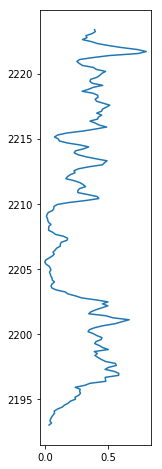

In [49]:
vsh = vshale(w.data['GR'], 40, 100)
depth = w.data['GR'].basis

plt.figure(figsize=(2, 8))
plt.plot(vsh[:200], depth[:200])

<hr />

<div>
<img src="https://avatars1.githubusercontent.com/u/1692321?s=50"><p style="text-align:center">© Agile Geoscience 2016</p>
</div>